In [1]:
# import all the libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# import csv file
housing = pd.read_csv("C:\\Users\\sadak\\Desktop\\datasets\\cali_housing.csv")
housing.head()
# median income expressed in tens of thousands; Eg: 3 is $30,000

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


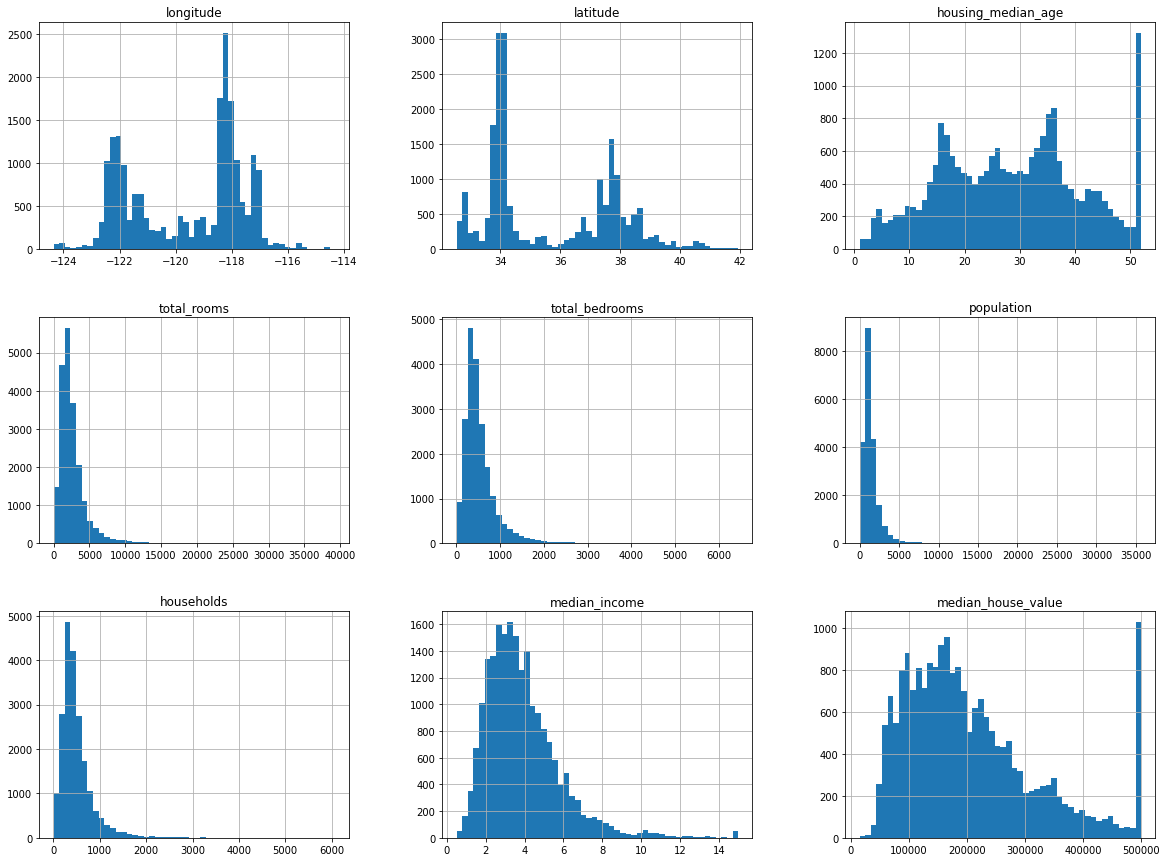

In [5]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [6]:
# function to split data into test set and train set
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[0:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]    

In [7]:
train_set, test_set = split_train_test(housing, 0.20)

In [8]:
housing["income_cat"] = pd.cut(housing["median_income"],bins=[0., 1.5, 3.0, 4.5, 6., np.inf],labels=[1, 2, 3, 4, 5])

In [9]:
# stratified shuffle to make sure that our train set is representative of all income categories.
# Or else will result in overfitting
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing,housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
# drop income_cat column as it is not needed
for col in (strat_train_set,strat_test_set):
    col.drop("income_cat",axis=1,inplace=True)

In [11]:
# create copy to explore data and get a feel for it
temp = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

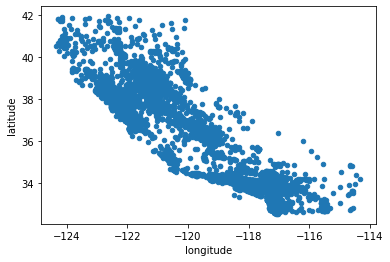

In [12]:
temp.plot(kind="scatter", x="longitude",y="latitude")

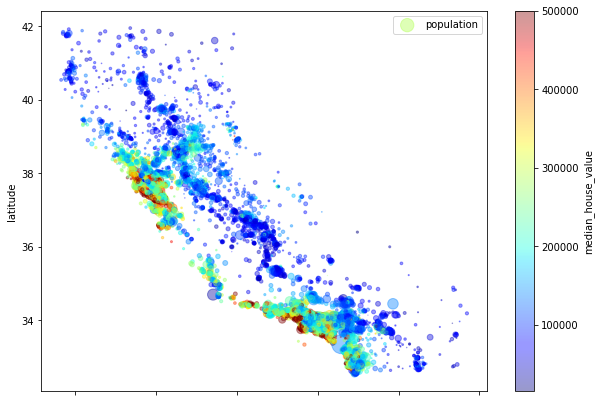

In [13]:
# house value based on density population across California
temp.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4,
             s=temp["population"]/100,label="population",figsize=(10,7),
            c="median_house_value",cmap=plt.get_cmap("jet"),colorbar=True)
plt.show()
# We can see that clusters near coast have high house prices

In [14]:
# see correlation b/w house_val and all other features
corr = temp.corr()
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


In [15]:
corr["median_house_value"].sort_values(ascending=False)
# strong correlation b/w house_val and median_income
# small negative correlation b/w house_val and latitude, meaning house prices go down as you go north

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

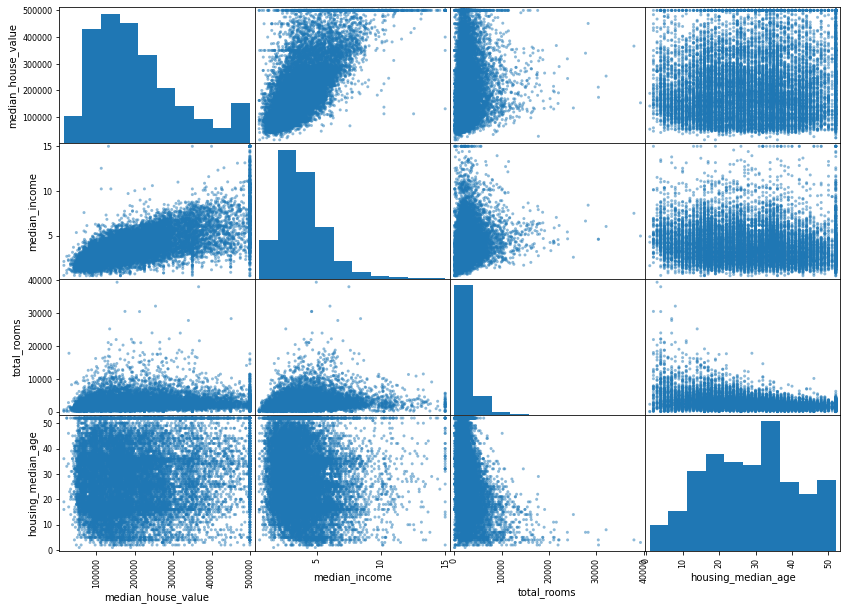

In [16]:
# plotting also helps visualize the correlation
# Here, we plot a few of the important correlations
attributes = ["median_house_value","median_income","total_rooms","housing_median_age"]
scatter_matrix(temp[attributes],figsize=(14,10))
plt.show()

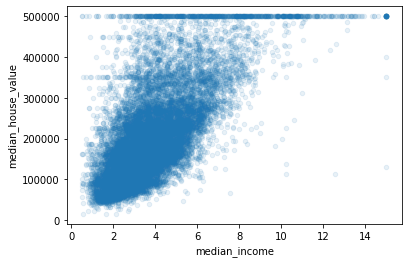

In [17]:
# focus on house_val affected by median_income as it is most affecting the prices
temp.plot(kind="scatter",x="median_income",y="median_house_value",alpha=0.1)
plt.show()

In [18]:
# create new features that will help us better understand the data
temp["rooms_per_household"] = temp["total_rooms"]/temp["households"]
temp["bedrooms_per_room"] = temp["total_bedrooms"]/temp["total_rooms"]
temp["population_per_household"] = temp["population"]/temp["households"]

# this combining of attributes is done with a complete transfomer class further down in the code

In [19]:
corr = temp.corr()
corr["median_house_value"].sort_values(ascending=False)
# rooms_per_household has a higher correlation than just total_rooms
# same case with bedrooms_per_room

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [20]:
# we will prepare the data for our model now
# let us create another fresh copy
housing = strat_train_set.drop("median_house_value",axis=1)
housing_label = strat_train_set["median_house_value"].copy()

In [21]:
# now, we will have to deal with null values that are present in total_bedrooms column
# we will use scikit learn's imputer to replace all null values with the median bedroom count
imputer = SimpleImputer(strategy="median")

# we will have to pass in a dataframe with only numerical info, therefore we need to remove the ocean_proximity column
housing_num = housing.drop("ocean_proximity",axis=1)

# let us pass in the dataframe to the imputer
imputer.fit(housing_num)

# the transform method gives out a numpy array, but we can convert it to a dataframe
temp = imputer.transform(housing_num)
housing_tr = pd.DataFrame(temp, columns=housing_num.columns, index=housing_num.index)

In [22]:
# we will deal with text data now, which is the ocean_proximity column
housing_cat = housing[["ocean_proximity"]]
# ML models prefer to work with numerical info, therefore we will convert the categorical text to numbers
# for this, we can use scikit learn's OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [23]:
# the data now needs to be feature scaled. This will make the model more accurate and better performing
# scikit learn provides transformation pipelines that hugely simplify the code needed to be written
# this pipeline can easily replace the imputer and OneHotEncoder we coded above
# a transformer class is also written to combine certain attributes, called CombinedAttributesAdder()

rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:,rooms_ix] / X[:,households_ix]
        population_per_household = X[:,population_ix] / X[:,households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ix] / X[:,rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attribs = attr_adder.transform(housing.values)

num_pipeline = Pipeline([
                ('imputer',SimpleImputer(strategy="median")),
                ('attr_adder',CombinedAttributesAdder()),
                ('std_scaler',StandardScaler()),
            ])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [24]:
# using columnTransformer to handle both categorical and numerical data at the same time

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", OneHotEncoder(), cat_attribs),
        ])
housing_final = full_pipeline.fit_transform(housing)

# We have now prepared the training data!
# Now, it is time to experiment with models

In [25]:
# Starting off with the simplest model, linear regression
lin_reg = LinearRegression()
lin_reg.fit(housing_final, housing_label)

# let us test to see if it is a good fit
temp_data = housing.iloc[:5]
temp_labels = housing_label.iloc[:5]
temp_data_prepared = full_pipeline.transform(temp_data)
predictions = lin_reg.predict(temp_data_prepared)
print(predictions)
print(list(temp_labels))

# we can see the differences now
# let us find how off our total predictions are using root mean squared error

housing_predictions = lin_reg.predict(housing_final)
lin_mse = mean_squared_error(housing_label, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_rmse)

# On average, our predictions are about $68,827 off from the actual values
# This is a very bad model, and is an example of underfitting
# A good remedy is to choose a more complex model

[210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
[286600.0, 340600.0, 196900.0, 46300.0, 254500.0]
68628.19819848922


In [26]:
# Here we try DecisionTreeRegressor, which is able to find complex nonlinear relationships

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_final, housing_label)

# testing the accuracy of the model using root mean squared error

housing_predictions = tree_reg.predict(housing_final)
tree_mse = mean_squared_error(housing_label, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

# A 0.0 rmse hints that the model is very badly overfitting the data
# This means that it will perform badly on test cases that are not part of the training set
# use scikit learn's cross validation feature to test overfitting
tree_scores = cross_val_score(tree_reg,housing_final, housing_label, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

def display_scores(scores):
    print("Scores: ",scores)
    print("Mean: ",scores.mean())
    print("Standard deviation: ", scores.std())
display_scores(tree_rmse_scores)

# the overfitting is now clear; this model is worse than linear regression

0.0
Scores:  [68064.85929684 66189.17653757 69921.67262215 70129.04536665
 71515.16914764 75941.25930916 69724.63604428 70217.29539812
 76341.31111475 70299.62699292]
Mean:  70834.40518300782
Standard deviation:  2989.0961527677296


In [27]:
# try RandomForestRegressor, as it trains multiple decision trees on subsets of the training set
# and averages the predictions for a better result

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_final, housing_label)
fr_predictions = forest_reg.predict(housing_final)
fr_rmse = np.sqrt(mean_squared_error(housing_label, fr_predictions))
print(fr_rmse)
fr_scores = cross_val_score(forest_reg, housing_final, housing_label, scoring="neg_mean_squared_error",cv=10)
fr_rmse_scores = np.sqrt(-fr_scores)
display_scores(fr_rmse_scores)

# this is not so bad, but there is still some overfitting

18439.837562703386
Scores:  [49251.60127781 48005.54143942 50229.96212552 52571.88015399
 49855.44961511 53581.97512978 48882.68466072 48008.43689344
 52938.04388338 50245.12828838]
Mean:  50357.07034675557
Standard deviation:  1915.431307432143


In [28]:
# Time to fine tune model
# using gridsearchcv to experiment with hyperparameter vals
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg,param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_final,housing_label)
grid_search.best_estimator_

# evaluation scores for each iteration of gridsearch

cv_res = grid_search.cv_results_
for mean_score, params in zip(cv_res['mean_test_score'], cv_res['params']):
    print(np.sqrt(-mean_score), params)

# fine tuning made the model perform a little better

63803.716572772144 {'max_features': 2, 'n_estimators': 3}
55563.05744467834 {'max_features': 2, 'n_estimators': 10}
52863.81481030381 {'max_features': 2, 'n_estimators': 30}
59399.451749905325 {'max_features': 4, 'n_estimators': 3}
53012.09624236522 {'max_features': 4, 'n_estimators': 10}
50635.84980125518 {'max_features': 4, 'n_estimators': 30}
59546.769760758616 {'max_features': 6, 'n_estimators': 3}
52618.752185575 {'max_features': 6, 'n_estimators': 10}
50029.78365945555 {'max_features': 6, 'n_estimators': 30}
59508.4382427122 {'max_features': 8, 'n_estimators': 3}
52069.253310428794 {'max_features': 8, 'n_estimators': 10}
50403.14676703725 {'max_features': 8, 'n_estimators': 30}
63131.57107061804 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54424.749394619335 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60647.16790838382 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52563.08888616698 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

In [30]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

x_test_final = full_pipeline.transform(x_test)

y_pred = final_model.predict(x_test_final)

mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 48302.10612035171
